INFO:root:Running in local test mode...
ERROR:root:Local gateway simulation failed: (<GatewayRuntimeErrorType.GATEWAY_RAISED_EXCEPTION: 5>, 'Traceback (most recent call last):\n  File "/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/base_gateway.py", line 132, in run\n    predictions, row_ids = self.get_all_predictions()\n                           ^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/base_gateway.py", line 107, in get_all_predictions\n    for data_batch, row_ids in self.generate_data_batches():\n  File "/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/default_gateway.py", line 27, in generate_data_batches\n    test = pl.read_csv(self.competition_data_dir / \'test.csv\')\n           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/usr/local/lib/python3.11/dist-packages/polars/_utils/deprecation.py", line 114, in wrapper\n    return function(*args, **kwargs)\n           ^

[LightGBM] [Info] Number of positive: 4662, number of negative: 4359
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38935
[LightGBM] [Info] Number of data points in the train set: 9021, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.516794 -> initscore=0.067202
[LightGBM] [Info] Start training from score 0.067202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

INFO:root:Model training completed successfully.
/tmp/ipykernel_13/366122865.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[col] = np.nan
/tmp/ipykernel_13/366122865.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[col] = np.nan
/tmp/ipykernel_13/366122865.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fra

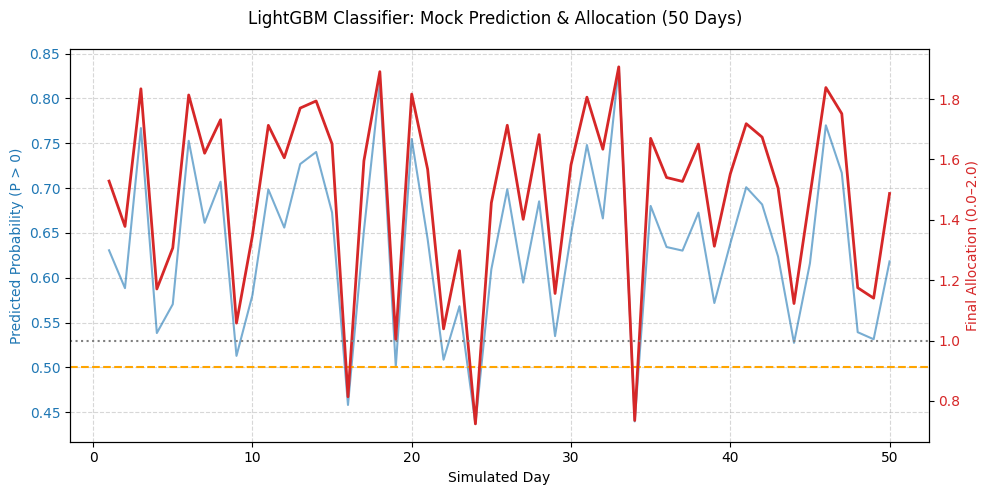

INFO:root:Dummy submission.parquet created successfully.


In [1]:
"""
LightGBM Market Prediction Pipeline
-----------------------------------
A modular implementation for Kaggle-compatible financial time series inference.

Includes:
- Feature engineering (lags, rolling stats, EMAs, interactions)
- Model training (LightGBM binary classifier)
- Prediction-to-allocation conversion
- Local and Kaggle-compatible inference modes
- Mock test visualization
"""

import os
import logging
from typing import List

import numpy as np
import pandas as pd
import polars as pl
import lightgbm as lgb
import matplotlib.pyplot as plt

# -------------------------------------------------------------------------
# Kaggle Evaluation Interface (with Local Mock Fallback)
# -------------------------------------------------------------------------
try:
    import kaggle_evaluation.default_inference_server as inference_server
except ImportError:

    class MockInferenceServer:
        """Mock inference server for local testing outside Kaggle."""

        def __init__(self, predict_fn):
            self.predict_fn = predict_fn

        def serve(self):
            logging.info("Mock Inference Server Running...")

        def run_local_gateway(self, path):
            logging.info(f"Mock Local Gateway Running with path: {path}")

    inference_server = MockInferenceServer

# -------------------------------------------------------------------------
# Global Configuration and Logging Setup
# -------------------------------------------------------------------------
logging.basicConfig(level=logging.INFO)
MODEL = None
TRAIN_COLS = None
TRAIN_MEANS = None

# -------------------------------------------------------------------------
# Feature Engineering
# -------------------------------------------------------------------------
def get_features(df: pl.DataFrame) -> List[str]:
    """Identify base feature columns dynamically.

    Args:
        df: Polars DataFrame with raw input data.

    Returns:
        List of feature column names.
    """
    exclude_cols = {
        'date_id', 'forward_returns', 'risk_free_rate',
        'market_forward_excess_returns', 'is_scored',
        'lagged_forward_returns', 'lagged_risk_free_rate',
        'lagged_market_forward_excess_returns'
    }
    return [col for col in df.columns if col not in exclude_cols]


def preprocess_data(df: pl.DataFrame, is_training: bool = False) -> pd.DataFrame:
    """Perform preprocessing and feature engineering.

    Steps:
        1. Create lag, rolling, and EMA features.
        2. Add interaction ratios and differences.
        3. Drop unused columns for modeling.

    Args:
        df: Polars DataFrame.
        is_training: If True, enables additional transformations for training.

    Returns:
        Processed pandas DataFrame.
    """
    if 'date_id' in df.columns:
        df = df.with_columns((pl.col('date_id') % 5).alias('day_of_cycle'))

    base_features = ['M1', 'E1', 'V1', 'S1', 'T1', 'P1', 'D1']
    rolling_windows = [5, 10, 20]
    lag_windows = [1, 5]

    expressions = []

    # Lag features
    for lag in lag_windows:
        for col in base_features:
            if col in df.columns:
                expressions.append(pl.col(col).shift(lag).alias(f"{col}_lag_{lag}"))

    # Rolling statistics
    for window in rolling_windows:
        for col in base_features:
            if col in df.columns:
                expressions += [
                    pl.col(col)
                    .rolling_mean(window_size=window, min_samples=1)
                    .alias(f"{col}_roll_mean_{window}"),
                    pl.col(col)
                    .rolling_std(window_size=window, min_samples=1)
                    .alias(f"{col}_roll_std_{window}")
                ]

    if expressions:
        df = df.with_columns(expressions)

    pdf = df.to_pandas()

    # Exponential Moving Averages (EMA)
    ema_windows = [10, 30, 60]
    for window in ema_windows:
        for col in base_features:
            if col in pdf.columns:
                pdf[f"{col}_ema_{window}"] = pdf[col].ewm(span=window, adjust=False).mean()

    # Interaction features
    feature_pairs = [('M1', 'M2'), ('E1', 'E2'), ('V1', 'V2'),
                     ('S1', 'S2'), ('T1', 'T2'), ('P1', 'P2'), ('D1', 'D2')]
    for col1, col2 in feature_pairs:
        if col1 in pdf.columns and col2 in pdf.columns:
            pdf[f"{col1}_div_{col2}"] = pdf[col1] / (pdf[col2].replace(0, 1e-6) + 1e-6)
            pdf[f"{col1}_minus_{col2}"] = pdf[col1] - pdf[col2]

    exclude_final = {
        'date_id', 'forward_returns', 'risk_free_rate',
        'market_forward_excess_returns', 'is_scored',
        'lagged_forward_returns', 'lagged_risk_free_rate',
        'lagged_market_forward_excess_returns'
    }
    final_cols = [c for c in pdf.columns if c not in exclude_final]
    return pdf[final_cols]


# -------------------------------------------------------------------------
# Model Training and Prediction
# -------------------------------------------------------------------------
def train_model(train_df: pl.DataFrame):
    """Train a LightGBM classifier on market excess returns."""
    global MODEL, TRAIN_COLS, TRAIN_MEANS

    y_train = (train_df['market_forward_excess_returns'].to_numpy() > 0).astype(int)
    X_train = preprocess_data(train_df, is_training=True)

    TRAIN_COLS = list(X_train.columns)
    TRAIN_MEANS = X_train.mean()
    X_train = X_train.fillna(TRAIN_MEANS)

    regressor = lgb.LGBMClassifier(
        objective='binary',
        n_estimators=4000,
        learning_rate=0.008,
        num_leaves=511,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=3.0,
        min_child_samples=15,
        random_state=42,
        n_jobs=4,
        boosting_type='gbdt'
    )

    MODEL = regressor
    logging.info(f"Training LightGBM model on {len(X_train)} samples with {len(TRAIN_COLS)} features...")
    MODEL.fit(X_train, y_train)
    logging.info("Model training completed successfully.")


def convert_prediction_to_allocation(prob: float) -> float:
    """Convert predicted probability to allocation value between 0.0 and 2.0."""
    confidence_multiplier = 4.5
    edge = prob - 0.5
    scaled = np.tanh(confidence_multiplier * edge)
    allocation = np.clip(1.0 + scaled, 0.0, 2.0)
    return float(allocation)


def predict(test: pl.DataFrame) -> float:
    """Main inference function required by Kaggle API."""
    global MODEL, TRAIN_COLS, TRAIN_MEANS

    is_mock_run = not os.getenv("KAGGLE_IS_COMPETITION_RERUN")
    default_return = (1.0, 0.5) if is_mock_run else 1.0

    if MODEL is None:
        train_path = os.path.join("/kaggle/input/hull-tactical-market-prediction/", "train.csv")
        try:
            train_df = pl.read_csv(train_path, try_parse_dates=True, infer_schema_length=100000)
            train_model(train_df)
        except Exception as e:
            logging.error(f"Training initialization failed: {e}")
            return default_return

    try:
        X_test = preprocess_data(test)
        for col in set(TRAIN_COLS) - set(X_test.columns):
            X_test[col] = np.nan
        X_test = X_test[TRAIN_COLS].fillna(TRAIN_MEANS)
    except Exception as e:
        logging.error(f"Feature preparation failed: {e}")
        return default_return

    try:
        prob = MODEL.predict_proba(X_test)[-1, 1]
        allocation = convert_prediction_to_allocation(prob)
        return (allocation, prob) if is_mock_run else allocation
    except Exception as e:
        logging.error(f"Inference failed: {e}")
        return default_return


# -------------------------------------------------------------------------
# Visualization
# -------------------------------------------------------------------------
def plot_results(results_df: pd.DataFrame):
    """Visualize predicted probabilities and allocations."""
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.set_xlabel("Simulated Day")
    ax1.set_ylabel("Predicted Probability (P > 0)", color="tab:blue")
    ax1.plot(results_df["day"], results_df["predicted_return"], color="tab:blue", alpha=0.6)
    ax1.axhline(0.5, color="orange", linestyle="--", label="Neutral (0.5)")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.grid(True, linestyle="--", alpha=0.5)

    ax2 = ax1.twinx()
    ax2.set_ylabel("Final Allocation (0.0–2.0)", color="tab:red")
    ax2.plot(results_df["day"], results_df["allocation"], color="tab:red", linewidth=2)
    ax2.axhline(1.0, color="gray", linestyle=":")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    fig.suptitle("LightGBM Classifier: Mock Prediction & Allocation (50 Days)")
    fig.tight_layout()
    plt.show()


# -------------------------------------------------------------------------
# Mock Simulation and Local Testing
# -------------------------------------------------------------------------
def run_mock_test_and_visualize():
    """Run a mock simulation and plot results."""
    mock_features = ['D1', 'D2', 'E1', 'E2', 'V1', 'V2',
                     'S1', 'S2', 'M1', 'M2', 'T1', 'T2', 'P1', 'P2']
    results = []

    init_data = {f: [np.random.rand()] for f in mock_features}
    init_data.update({
        "market_forward_excess_returns": [np.random.uniform(-0.01, 0.01)],
        "date_id": [1000]
    })
    predict(pl.DataFrame(init_data))

    for day in range(50):
        day_data = {
            c: [np.random.uniform(0.1, 0.9) if c == "M1" else np.random.rand()]
            for c in mock_features
        }
        day_data.update({
            "market_forward_excess_returns": [np.random.uniform(-0.01, 0.01)],
            "date_id": [1001 + day]
        })
        allocation, p = predict(pl.DataFrame(day_data))
        results.append({"day": day + 1, "predicted_return": p, "allocation": allocation})

    df = pd.DataFrame(results)
    logging.info(f"Mean Predicted P(>0): {df['predicted_return'].mean():.6f}")
    logging.info(f"Mean Allocation: {df['allocation'].mean():.4f}")
    plot_results(df)


# -------------------------------------------------------------------------
# Main Entry Point
# -------------------------------------------------------------------------
def main():
    """Entry point for both Kaggle and local environments."""
    server_instance = inference_server.DefaultInferenceServer(predict)

    if os.getenv("KAGGLE_IS_COMPETITION_RERUN"):
        server_instance.serve()
    else:
        logging.info("Running in local test mode...")
        try:
            local_path = os.path.join(os.getcwd(), "kaggle_input/hull-tactical-market-prediction/")
            server_instance.run_local_gateway((local_path,))
        except Exception as e:
            logging.error(f"Local gateway simulation failed: {e}")
            run_mock_test_and_visualize()

            dummy = pl.DataFrame({"date_id": [999], "allocation": [1.0]})
            dummy.write_parquet("submission.parquet")
            logging.info("Dummy submission.parquet created successfully.")


if __name__ == "__main__":
    main()
